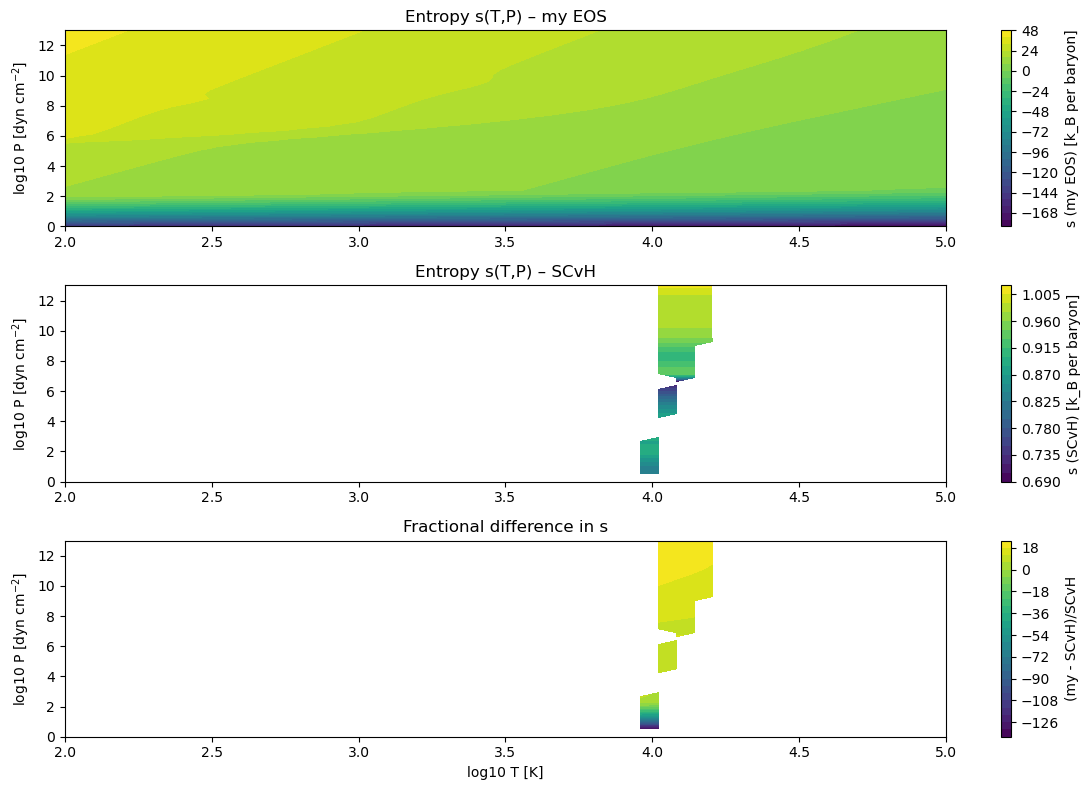

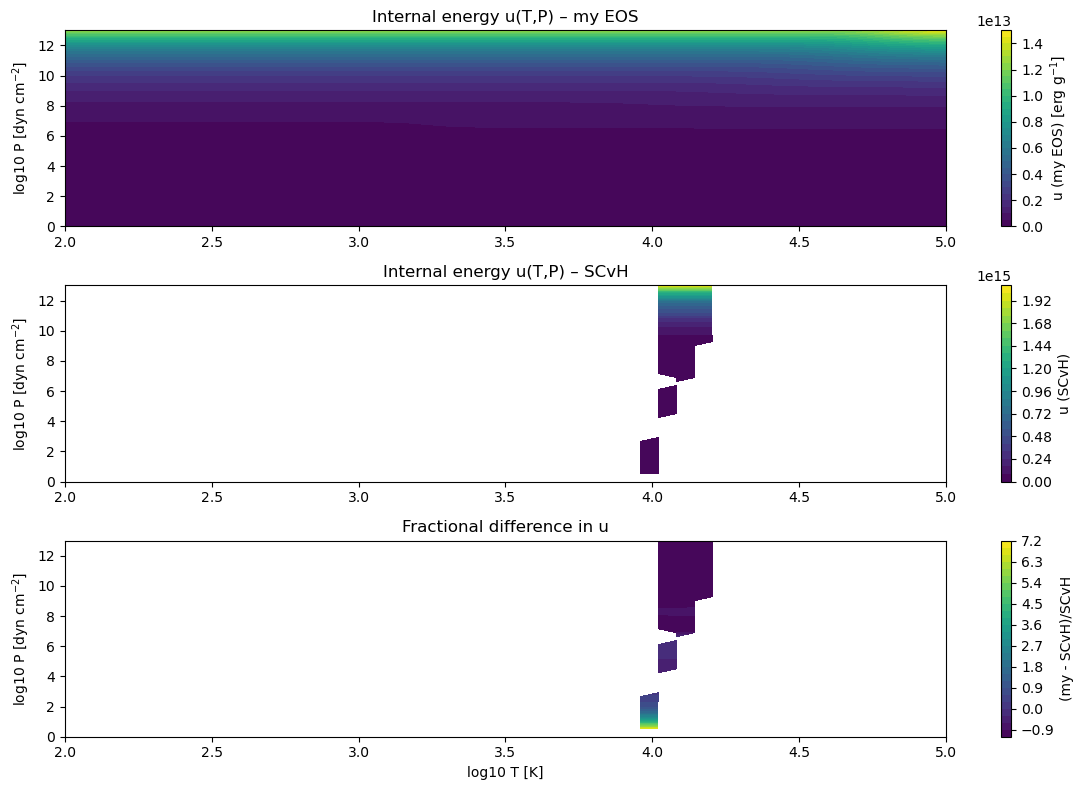

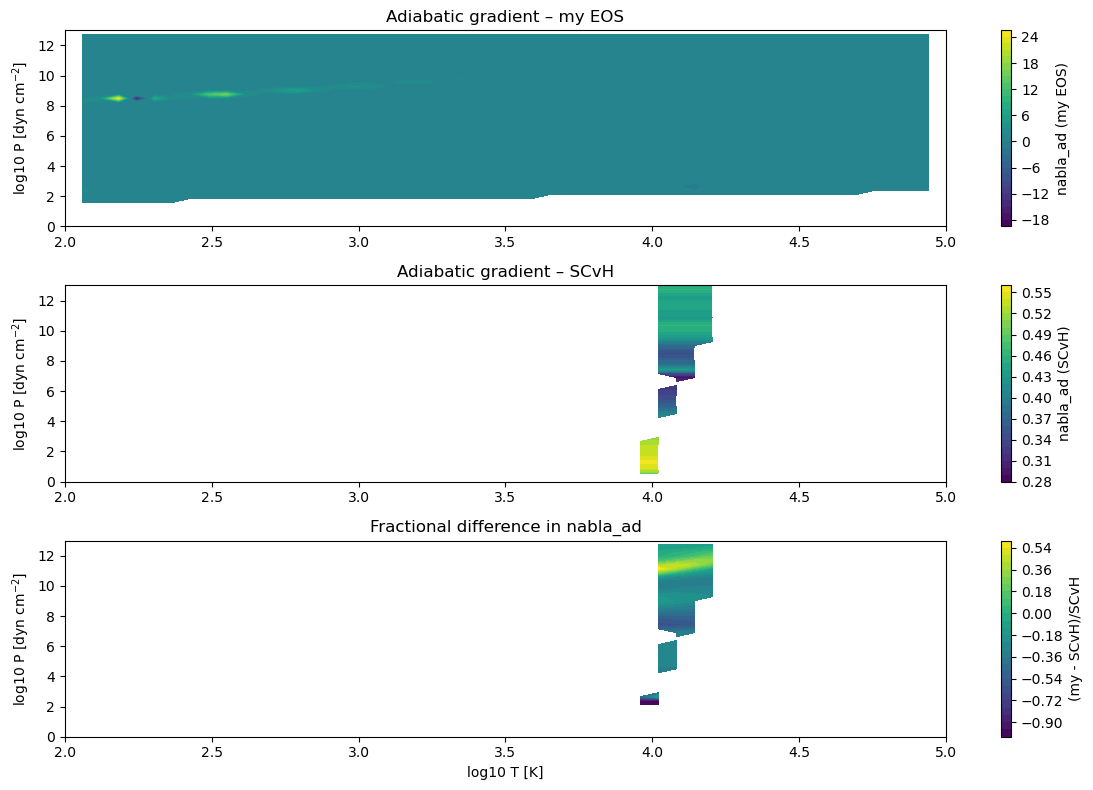

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

# constants (cgs)

k_B       = 1.380649e-16      # boltzmann constant 
h         = 6.62607015e-27    # planck constant 
m_e       = 9.10938356e-28    # electron mass
m_H       = 1.6735575e-24     # hydrogen atom mass 
m_H2      = 2.0 * m_H         # H2 molecule mass 
eV_to_erg = 1.602176634e-12   # 1 eV in erg

chi_H_eV  = 13.6              # H ionization energy (eV)
chi_H_erg = chi_H_eV * eV_to_erg

E_b_H2_eV  = 4.52             # H2 bond energy (eV)
E_b_H2_erg = E_b_H2_eV * eV_to_erg

theta_v_H2 = 6100.0    # H2 vibrational temperature K
theta_r_H2 = 85.0      # H2 rotational temperature K


# thermal de broglie wavelength

def thermal_lambda(mass, T):
#lambda = sqrt( h^2 / (2π m kT) ).
    T = np.asarray(T, dtype=float)
    return np.sqrt(h**2 / (2.0 * np.pi * mass * k_B * T))


# partition functions


# 2 Internal partition function for HI

def Z_int_HI(T):
    """
    Internal partition function of neutral hydrogen
    temperatures in this problem (10^2–10^5 K) 
    almost all HI is in the ground state so approximate,
     Z_int,HI ≈ 2.
    """
    if np.isscalar(T):
        return 2.0
    else:
        return 2.0 * np.ones_like(T, dtype=float)



# 2.2 H2: electronic, vibrational, rotational Z


def _as_array(T):
    """returns a 1D float array and just in case flags a scalar"""
    is_scalar = np.isscalar(T)
    T_arr = np.array(T, dtype=float, ndmin=1)
    return T_arr, is_scalar

def Z_elec_H2(T):
    """
    electronic partition function for H2
        Z_elec,H2 ≈ 1 + exp(-E_b / kT),
        E_b = 4.52 eV
    """
    T_arr, is_scalar = _as_array(T)
    Z_arr = 1.0 + np.exp(-E_b_H2_erg / (k_B * T_arr))
    return float(Z_arr[0]) if is_scalar else Z_arr


def Z_vib_H2(T, n_vib_max=100):
    """
    vibrational partition function for H2 (harmonic oscillator):
        E_n = k_B * theta_v * (n + 1/2), n = 0..n_vib_max
        Z_vib = sum exp(-E_n / kT).
    """
    T_arr, is_scalar = _as_array(T)
    Z_arr = np.zeros_like(T_arr)

    for n in range(0, n_vib_max + 1):
        E_n = k_B * theta_v_H2 * (n + 0.5)
        Z_arr += np.exp(-E_n / (k_B * T_arr))

    return float(Z_arr[0]) if is_scalar else Z_arr


def Z_rot_H2(T, j_rot_max=100):
    """
    Rotational partition function for H2 including ortho/para
        E_j = k_B * theta_r * j(j+1), j = 0..j_rot_max
        g_j = (2j+1)          for even j (para-H2)
        g_j = 3(2j+1)         for odd  j (ortho-H2)
    """
    T_arr, is_scalar = _as_array(T)
    Z_arr = np.zeros_like(T_arr)

    for j in range(0, j_rot_max + 1):
        spin_deg = 1.0 if (j % 2 == 0) else 3.0
        g_j = (2*j + 1) * spin_deg
        E_j = k_B * theta_r_H2 * j * (j + 1)
        Z_arr += g_j * np.exp(-E_j / (k_B * T_arr))

    return float(Z_arr[0]) if is_scalar else Z_arr


def Z_int_H2(T, n_vib_max=100, j_rot_max=100):
    """
    Total internal partition function for H2
    Z_int,H2 = Z_elec,H2 * Z_vib,H2 * Z_rot,H2
    """
    T_arr, is_scalar = _as_array(T)

    Z_e = Z_elec_H2(T_arr)           # returns array because input is array
    Z_v = Z_vib_H2(T_arr, n_vib_max=n_vib_max)
    Z_r = Z_rot_H2(T_arr, j_rot_max=j_rot_max)

    Z_arr = Z_e * Z_v * Z_r
    return float(Z_arr[0]) if is_scalar else Z_arr



# 3 Saha

def saha_factor_H_ionization(T, Z_HI=None):
    """
    Saha factor 
    n_e n_p / n_HI = S(T)

    S(T) = (2π m_e kT / h^2)^(3/2)
           * (2 Z_p Z_e / Z_HI) * exp(-chi_H / kT),
        Z_p = 1, Z_e = 2.
    """
    T_arr, is_scalar = _as_array(T)
    if Z_HI is None:
        Z_HI_arr = Z_int_HI(T_arr)
    else:
        Z_HI_arr = Z_HI

    pref   = (2.0 * np.pi * m_e * k_B * T_arr / h**2)**1.5
    Z_p    = 1.0
    Z_e    = 2.0
    Z_rat  = (Z_p * Z_e) / Z_HI_arr
    expo   = np.exp(-chi_H_erg / (k_B * T_arr))
    S_arr  = pref * Z_rat * expo

    return float(S_arr[0]) if is_scalar else S_arr


def saha_factor_H2_dissociation(T, Z_HI=None, Z_H2=None,
                                n_vib_max=100, j_rot_max=100):
    """
        n_HI^2 / n_H2 = K(T).

    using the translational and internal partition functions
        K(T) = (Z_tr,HI^2 / Z_tr,H2)
               * (Z_int,HI^2 / Z_int,H2)
               * exp(-E_b / kT),
     Z_tr ~ 1 / lambda^3 per particle.
    """
    T_arr, is_scalar = _as_array(T)

    if Z_HI is None:
        Z_HI_arr = Z_int_HI(T_arr)
    else:
        Z_HI_arr = Z_HI

    if Z_H2 is None:
        Z_H2_arr = Z_int_H2(T_arr, n_vib_max=n_vib_max, j_rot_max=j_rot_max)
    else:
        Z_H2_arr = Z_H2

    lam_HI = thermal_lambda(m_H,  T_arr)
    lam_H2 = thermal_lambda(m_H2, T_arr)

    Ztr_HI = 1.0 / lam_HI**3
    Ztr_H2 = 1.0 / lam_H2**3

    transl_ratio   = (Ztr_HI**2) / Ztr_H2
    internal_ratio = (Z_HI_arr**2) / Z_H2_arr
    expo           = np.exp(-E_b_H2_erg / (k_B * T_arr))

    K_arr = transl_ratio * internal_ratio * expo
    return float(K_arr[0]) if is_scalar else K_arr


# 4 COMPOSITION AT GIVEN (T,P)


def solve_composition_H2_HI_HII(T, P,
                                n_vib_max=100, j_rot_max=100,
                                tol=1e-6, max_iter=100):
    """
    Solving for n_H2, n_HI, n_HII, n_e at (T, P).

    we don't know,
      n_H2, n_HI, n_HII  (and n_e = n_HII)

    constraints
      H2 <-> 2 HI       n_HI^2 / n_H2 = K(T)
      HI <-> HII + e-    n_HII^2 / n_HI = S_H(T)
      Charge neutrality   n_e = n_HII
      Ideal gas        P = (n_H2 + n_HI + 2 n_HII) kT

    y = n_HI. 

      n_H2  = y^2 / K
      n_HII = sqrt(S_H * y)
      N     = P / (kT)

      f(y) = y^2 / K + y + 2 sqrt(S_H y) - N = 0

    solve f(y) = 0 by bisection on y >= 0.
    """
    # total particle density (ideal gas)
    N   = P / (k_B * T)

    ZHI = Z_int_HI(T)
    ZH2 = Z_int_H2(T, n_vib_max=n_vib_max, j_rot_max=j_rot_max)

    S_H  = saha_factor_H_ionization(T, Z_HI=ZHI)
    K_H2 = saha_factor_H2_dissociation(T, Z_HI=ZHI, Z_H2=ZH2,
                                       n_vib_max=n_vib_max,
                                       j_rot_max=j_rot_max)

    def f(y):
        y = max(y, 0.0)
        n_H2  = y**2 / K_H2
        n_HII = math.sqrt(S_H * y)
        return n_H2 + y + 2.0 * n_HII - N

    # bracket root
    y_min = 0.0
    y_max = max(N, 1e-20)
    f_min = f(y_min)
    f_max = f(y_max)

    if f_min * f_max > 0:
        # fallback, mostly neutral gas
        n_HI  = N
        n_HII = 0.0
        n_H2  = 0.0
        n_e   = 0.0
        return n_H2, n_HI, n_HII, n_e

    for _ in range(max_iter):
        y_mid = 0.5 * (y_min + y_max)
        f_mid = f(y_mid)
        if abs(f_mid) < tol * N:
            break
        if f_min * f_mid < 0:
            y_max = y_mid
            f_max = f_mid
        else:
            y_min = y_mid
            f_min = f_mid

    n_HI  = max(y_mid, 0.0)
    n_H2  = n_HI**2 / K_H2
    n_HII = math.sqrt(S_H * n_HI)
    n_e   = n_HII
    return n_H2, n_HI, n_HII, n_e



# 5 fee energy entropy and internal energy


def specific_free_energy_species(T, n_i, m_i, Z_int_i):
    """
    specific helmholtz free energy of species i (per unit mass)

        F_i / N_i = kT [ln(n_i λ_i^3 / Z_int_i) - 1]
        a_i       = (F_i / N_i) / m_i.
    """
    if n_i <= 0:
        return 0.0

    lam = thermal_lambda(m_i, T)
    arg = n_i * lam**3 / Z_int_i
    arg = max(arg, 1e-300)
    f_per_particle = k_B * T * (math.log(arg) - 1.0)
    a_i = f_per_particle / m_i
    return a_i


def specific_entropy_species(T, n_i, m_i, Z_int_func, dT_frac=1e-4):
    """
    specific entropy per mass
        s_i = - (∂a_i / ∂T)_ρi  (derivative)
    """
    if n_i <= 0:
        return 0.0

    dT      = dT_frac * T
    T_plus  = T + dT
    T_minus = max(T - dT, 1e-3)

    Z_plus  = Z_int_func(T_plus)
    Z_minus = Z_int_func(T_minus)

    a_plus  = specific_free_energy_species(T_plus,  n_i, m_i, Z_plus)
    a_minus = specific_free_energy_species(T_minus, n_i, m_i, Z_minus)

    da_dT = (a_plus - a_minus) / (T_plus - T_minus)
    s_i   = -da_dT
    return s_i


def specific_internal_energy_species(T, n_i, m_i, Z_int_func, dT_frac=1e-4):
    """
    specific internal energy per mass
        u_i = a_i + T s_i.
    """
    if n_i <= 0:
        return 0.0

    Z_here = Z_int_func(T)
    a_i    = specific_free_energy_species(T, n_i, m_i, Z_here)
    s_i    = specific_entropy_species(T, n_i, m_i, Z_int_func, dT_frac=dT_frac)
    return a_i + T * s_i


def mixture_specific_entropy(T, P,
                             n_vib_max=100, j_rot_max=100):
    """
    total specific entropy s(T,P) of the mixture (H2 + HI + HII)
        s_mix = Σ_i Y_i s_i,
    with mass fractions Y_i.
    """
    n_H2, n_HI, n_HII, n_e = solve_composition_H2_HI_HII(
        T, P,
        n_vib_max=n_vib_max,
        j_rot_max=j_rot_max)

    n_H_nuc = 2.0 * n_H2 + n_HI + n_HII
    if n_H_nuc <= 0:
        return 0.0

    rho = m_H * n_H_nuc

    rho_H2  = 2.0 * m_H * n_H2
    rho_HI  = m_H * n_HI
    rho_HII = m_H * n_HII

    Y_H2  = rho_H2  / rho
    Y_HI  = rho_HI  / rho
    Y_HII = rho_HII / rho

    s_H2 = specific_entropy_species(
        T, n_H2, m_H2,
        Z_int_func=lambda TT: Z_int_H2(TT, n_vib_max=n_vib_max,
                                       j_rot_max=j_rot_max))
    s_HI = specific_entropy_species(
        T, n_HI, m_H,
        Z_int_func=lambda TT: Z_int_HI(TT))
    s_HII = specific_entropy_species(
        T, n_HII, m_H,
        Z_int_func=lambda TT: 1.0)

    s_mix = Y_H2 * s_H2 + Y_HI * s_HI + Y_HII * s_HII
    return s_mix


def mixture_specific_internal_energy(T, P,
                                     n_vib_max=100, j_rot_max=100):
    """
    total specific internal energy u(T,P) of the mixture

        u_mix = Σ_i Y_i u_i
    """
    n_H2, n_HI, n_HII, n_e = solve_composition_H2_HI_HII(
        T, P,
        n_vib_max=n_vib_max,
        j_rot_max=j_rot_max)

    n_H_nuc = 2.0 * n_H2 + n_HI + n_HII
    if n_H_nuc <= 0:
        return 0.0

    rho = m_H * n_H_nuc

    rho_H2  = 2.0 * m_H * n_H2
    rho_HI  = m_H * n_HI
    rho_HII = m_H * n_HII

    Y_H2  = rho_H2  / rho
    Y_HI  = rho_HI  / rho
    Y_HII = rho_HII / rho

    u_H2 = specific_internal_energy_species(
        T, n_H2, m_H2,
        Z_int_func=lambda TT: Z_int_H2(TT, n_vib_max=n_vib_max,
                                       j_rot_max=j_rot_max))
    u_HI = specific_internal_energy_species(
        T, n_HI, m_H,
        Z_int_func=lambda TT: Z_int_HI(TT))
    u_HII = specific_internal_energy_species(
        T, n_HII, m_H,
        Z_int_func=lambda TT: 1.0)

    u_mix = Y_H2 * u_H2 + Y_HI * u_HI + Y_HII * u_HII
    return u_mix



# 6. adiabtic gradient entropy grid


def compute_nabla_ad_grid(T_grid, P_grid, s_grid, min_dlogS_dlogT=1e-3):
    """
    computing adiabatic gradient

        nabla_ad = - (∂ ln S / ∂ ln P)_T / (∂ ln S / ∂ ln T)_P

    using central finite differences on a log-spaced T,P grid

   skip points where |∂ ln S / ∂ ln T| is too small had some problems with spikes
    """
    T_grid = np.asarray(T_grid)
    P_grid = np.asarray(P_grid)
    s_grid = np.asarray(s_grid)

    nT = len(T_grid)
    nP = len(P_grid)

    logT = np.log(T_grid)
    logP = np.log(P_grid)
    tiny = 1e-300
    logS = np.log(np.maximum(s_grid, tiny))

    nabla_ad = np.full_like(s_grid, np.nan, dtype=float)

    for i in range(1, nT - 1):
        for j in range(1, nP - 1):
            dlogS_dlogP_T = (logS[i, j+1] - logS[i, j-1]) / (logP[j+1] - logP[j-1])
            dlogS_dlogT_P = (logS[i+1, j] - logS[i-1, j]) / (logT[i+1] - logT[i-1])

            if abs(dlogS_dlogT_P) < min_dlogS_dlogT:
                continue

            nabla_ad[i, j] = - dlogS_dlogP_T / dlogS_dlogT_P

    return nabla_ad



# 7  SCvH table 


def load_scvh_h_table(filename="h_tab_i.dat"):
    """
    SCvH H EOS table from h_tab_i.dat.
    """
    with open(filename, "r") as f:
        lines = f.readlines()

    header_indices = []
    for i, line in enumerate(lines):
        parts = line.split()
        if len(parts) == 2:
            try:
                float(parts[0]); float(parts[1])
                header_indices.append(i)
            except ValueError:
                pass

    logT_list    = []
    logP_blocks  = []
    logU_blocks  = []
    logS_blocks  = []
    nabla_blocks = []

    for idx in header_indices:
        logT, nP = map(float, lines[idx].split())
        nP = int(nP)
        logT_list.append(logT)
        rows = [list(map(float, lines[idx + 1 + j].split())) for j in range(nP)]
        rows = np.array(rows)
        logP_blocks.append(rows[:, 4])
        logU_blocks.append(rows[:, 5])
        logS_blocks.append(rows[:, 6])
        nabla_blocks.append(rows[:, 8])

    logT_arr = np.array(logT_list)
    logP_blocks  = [np.array(a) for a in logP_blocks]
    logU_blocks  = [np.array(a) for a in logU_blocks]
    logS_blocks  = [np.array(a) for a in logS_blocks]
    nabla_blocks = [np.array(a) for a in nabla_blocks]

    return logT_arr, logP_blocks, logU_blocks, logS_blocks, nabla_blocks


def make_scvh_interpolators(logT_arr, logP_blocks, logU_blocks,
                            logS_blocks, nabla_blocks):
    """
    return interpolation functions

      scvh_S(T,P)  – entropy [k_B per baryon]
      scvh_U(T,P)  – internal energy
      scvh_nabla(T,P)

    uses linear interpolation in logP inside each T block and
    linear interpolation in logT between blocks
    """
    def interp_quantity(T, P, which="S"):
        logT = math.log10(T)
        logP = math.log10(P)

        if logT < logT_arr[0] or logT > logT_arr[-1]:
            return np.nan

        i1 = np.searchsorted(logT_arr, logT)
        if i1 == 0:
            i0 = 0; i1 = 1
        elif i1 == len(logT_arr):
            i0 = len(logT_arr) - 2; i1 = len(logT_arr) - 1
        else:
            i0 = i1 - 1

        t0, t1 = logT_arr[i0], logT_arr[i1]

        def interp_block(i):
            logP_i = logP_blocks[i]
            if logP < logP_i.min() or logP > logP_i.max():
                return np.nan

            if which == "S":
                logQ_i   = logS_blocks[i]
                logQ_val = np.interp(logP, logP_i, logQ_i)
                return 10.0**logQ_val
            elif which == "U":
                logQ_i   = logU_blocks[i]
                logQ_val = np.interp(logP, logP_i, logQ_i)
                return 10.0**logQ_val
            elif which == "nabla":
                Q_i = nabla_blocks[i]
                return float(np.interp(logP, logP_i, Q_i))
            else:
                return np.nan

        q0 = interp_block(i0)
        q1 = interp_block(i1)
        if np.isnan(q0) or np.isnan(q1):
            return np.nan
        if t1 == t0:
            return q0
        w = (logT - t0) / (t1 - t0)
        return q0 + (q1 - q0) * w

    def scvh_S(T, P):
        return interp_quantity(T, P, which="S")

    def scvh_U(T, P):
        return interp_quantity(T, P, which="U")

    def scvh_nabla(T, P):
        return interp_quantity(T, P, which="nabla")

    return scvh_S, scvh_U, scvh_nabla


# 8 EOS and comparison

if __name__ == "__main__":

    # T,P grid
    T_min, T_max = 1.0e2, 1.0e5
    P_min, P_max = 1.0,   1.0e13

    nT = 50
    nP = 50

    T_grid = np.logspace(np.log10(T_min), np.log10(T_max), nT)
    P_grid = np.logspace(np.log10(P_min), np.log10(P_max), nP)

    logT = np.log10(T_grid)
    logP = np.log10(P_grid)
    LOGT, LOGP = np.meshgrid(logT, logP, indexing="ij")

    # EOS, s(T,P) and u(T,P)

    s_grid = np.zeros((nT, nP))
    u_grid = np.zeros((nT, nP))

    for i, T_val in enumerate(T_grid):
        for j, P_val in enumerate(P_grid):
            s_grid[i, j] = mixture_specific_entropy(T_val, P_val)
            u_grid[i, j] = mixture_specific_internal_energy(T_val, P_val)

    # converting entropy to k_B per baryon to compare with SCvH
    s_my_kB = s_grid * m_H / k_B   # dimensionless

    # EOS, adiabatic gradient

    nabla_ad_grid = compute_nabla_ad_grid(T_grid, P_grid, s_grid)

    # SCvH and build interpolators
  
    logT_arr, logP_blocks, logU_blocks, logS_blocks, nabla_blocks = \
        load_scvh_h_table("h_tab_i.dat")
    scvh_S, scvh_U, scvh_nabla = make_scvh_interpolators(
        logT_arr, logP_blocks, logU_blocks, logS_blocks, nabla_blocks)


    #SCvH on same grid

    s_scvh_grid     = np.zeros_like(s_grid) * np.nan
    u_scvh_grid     = np.zeros_like(u_grid) * np.nan
    nabla_scvh_grid = np.zeros_like(nabla_ad_grid) * np.nan

    for i, T_val in enumerate(T_grid):
        for j, P_val in enumerate(P_grid):
            s_scvh_grid[i, j]     = scvh_S(T_val, P_val)
            u_scvh_grid[i, j]     = scvh_U(T_val, P_val)
            nabla_scvh_grid[i, j] = scvh_nabla(T_val, P_val)

    #fractional differences (mask NaNs)
    with np.errstate(invalid="ignore", divide="ignore"):
        frac_diff_s     = (s_my_kB      - s_scvh_grid)     / s_scvh_grid
        frac_diff_u     = (u_grid       - u_scvh_grid)     / u_scvh_grid
        frac_diff_nabla = (nabla_ad_grid - nabla_scvh_grid) / nabla_scvh_grid

    s_mask     = np.ma.masked_invalid(frac_diff_s)
    u_mask     = np.ma.masked_invalid(frac_diff_u)
    nabla_mask = np.ma.masked_invalid(frac_diff_nabla)


    # Plots
    #entropy comparison 
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.contourf(LOGT, LOGP, s_my_kB.T, levels=30)
    plt.colorbar(label="s (my EOS) [k_B per baryon]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Entropy s(T,P) – my EOS")

    plt.subplot(3, 1, 2)
    plt.contourf(LOGT, LOGP, s_scvh_grid.T, levels=30)
    plt.colorbar(label="s (SCvH) [k_B per baryon]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Entropy s(T,P) – SCvH")

    plt.subplot(3, 1, 3)
    plt.contourf(LOGT, LOGP, s_mask.T, levels=30)
    plt.colorbar(label="(my - SCvH)/SCvH")
    plt.xlabel("log10 T [K]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Fractional difference in s")

    plt.tight_layout()
    plt.show()

    #Internal energy comparison 
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.contourf(LOGT, LOGP, u_grid.T, levels=30)
    plt.colorbar(label="u (my EOS) [erg g$^{-1}$]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Internal energy u(T,P) – my EOS")

    plt.subplot(3, 1, 2)
    plt.contourf(LOGT, LOGP, u_scvh_grid.T, levels=30)
    plt.colorbar(label="u (SCvH)")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Internal energy u(T,P) – SCvH")

    plt.subplot(3, 1, 3)
    plt.contourf(LOGT, LOGP, u_mask.T, levels=30)
    plt.colorbar(label="(my - SCvH)/SCvH")
    plt.xlabel("log10 T [K]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Fractional difference in u")

    plt.tight_layout()
    plt.show()

    # Adiabatic gradient comparison 
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.contourf(LOGT, LOGP, nabla_ad_grid.T, levels=30)
    plt.colorbar(label="nabla_ad (my EOS)")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Adiabatic gradient – my EOS")

    plt.subplot(3, 1, 2)
    plt.contourf(LOGT, LOGP, nabla_scvh_grid.T, levels=30)
    plt.colorbar(label="nabla_ad (SCvH)")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Adiabatic gradient – SCvH")

    plt.subplot(3, 1, 3)
    plt.contourf(LOGT, LOGP, nabla_mask.T, levels=30)
    plt.colorbar(label="(my - SCvH)/SCvH")
    plt.xlabel("log10 T [K]")
    plt.ylabel("log10 P [dyn cm$^{-2}$]")
    plt.title("Fractional difference in nabla_ad")

    plt.tight_layout()
    plt.show()
